<a href="https://colab.research.google.com/github/felixzhao/title_catgories_classification/blob/main/JTC_v3_5_Hierarchial_model_implementation_topn_deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install dependency

In [1]:
! pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=aa84415e6076dc2f762d040483b9bb5401bb45dce515ba18af967d7572545774
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


# load packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
import json
import pickle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

from sentence_transformers import SentenceTransformer, util
from sklearn import metrics

In [4]:
from typing import Any, Optional

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import pickle

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")

load data
This work loads data from google drive. Please put the files into "trademe_data" folder under the root of google drive.

Then run the following code to mount the google drive in colab.

You can follow the guide. https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a

In [6]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "drive/MyDrive/trademe_data/"

Mounted at /content/drive


# load  data

In [16]:
raw_path = f"{root_path}raw.csv"
c3_dict_path = f"{root_path}c3_dict.json"
c1_dict_path = f"{root_path}c1_dict.json"

c1_mapping_path = f"{root_path}c1_mapping.json"
c2_mapping_path = f"{root_path}c2_mapping.json"
c3_mapping_path = f"{root_path}c3_mapping.json"

In [17]:
raw_df = pd.read_csv(raw_path)
raw_df.head(1)

,Unnamed: 0,x_title,y_cat_id,cat_1,cat_2,cat_3,x_title_feature
0,0,unqualified asbestos remover,5192,trades & services,labourers,labourers,unqualifi asbesto remov


In [18]:
raw_df = raw_df[['y_cat_id', 'x_title_feature', 'cat_1', 'cat_2','cat_3']]
print(len(raw_df))
raw_df.head()

20000


,y_cat_id,x_title_feature,cat_1,cat_2,cat_3
0,5192,unqualifi asbesto remov,trades & services,labourers,labourers
1,5123,senior test analyst,it,testing,testing
2,6894,ict trainer supervisor,education,tutoring & training,tutoring & training
3,5197,automot specialist multi facet posit,trades & services,technicians,technicians
4,5114,busi analyst,it,business & systems analysts,business & systems analysts


### load level dicts

In [19]:
c3_dict = json.load(open(c3_dict_path))
print(len(c3_dict.keys()))
c3_ununique_node_c2_list = c3_dict.keys()
c3_ununique_node_c2_list

3


dict_keys(['accountants', 'drivers & couriers', 'nursing & midwifery'])

In [20]:
c1_dict = json.load(open(c1_dict_path))
print(len(c1_dict.keys()))
c1_ununique_node_c2_list = c1_dict.keys()
c1_ununique_node_c2_list

10


dict_keys(['administration', 'analysts', 'architects', 'drafting', 'electrical', 'health & safety', 'management', 'project management', 'security', 'supervisors & forepersons'])

## load id and label mapping

In [21]:
c1_mapping = json.load(open(c1_mapping_path))
print(len(c1_mapping.keys()))
c1_mapping

10


{'administration': {'healthcare': 5083, 'office & administration': 5156},
 'analysts': {'banking, finance & insurance': 5022, 'accounting': 6889},
 'architects': {'architecture': 5034, 'it': 5113},
 'drafting': {'architecture': 5035, 'engineering': 5059},
 'electrical': {'engineering': 5060, 'trades & services': 5188},
 'health & safety': {'construction & roading': 4957, 'hr & recruitment': 4958},
 'management': {'automotive': 4962,
  'accounting': 5011,
  'banking, finance & insurance': 5030,
  'customer service': 5047,
  'engineering': 5063,
  'transport & logistics': 5072,
  'healthcare': 5088,
  'hospitality & tourism': 5103,
  'it': 5117,
  'manufacturing & operations': 5136,
  'marketing, media & communications': 5151,
  'retail': 5174},
 'project management': {'engineering': 5065, 'it': 5120},
 'security': {'trades & services': 5196, 'it': 6899},
 'supervisors & forepersons': {'construction & roading': 5042,
  'manufacturing & operations': 6901}}

In [22]:
def read_from_file_pickle(file_name):
    res = None
    with open(file_name, "rb") as file:
        res = pickle.load(file) 
    return res 

In [23]:
c2_mapping = read_from_file_pickle(c2_mapping_path)
print(len(c2_mapping.keys()))

149


In [24]:
c3_mapping = json.load(open(c3_mapping_path))
print(len(c3_mapping.keys()))
c3_mapping

3


{'accountants': {'business advisory services': 621,
  'assistant accountants': 6882,
  'audit': 6883,
  'financial accounting & reporting': 6884,
  'general / ca': 6885,
  'management accountants': 6886,
  'tax': 6887},
 'drivers & couriers': {'couriers': 6908, 'truck ht': 6909},
 'nursing & midwifery': {'community & primary care': 900,
  'critical care & emergency': 904,
  'medical': 906,
  'mental health': 907,
  'paediatrics': 910,
  'surgical': 916,
  'theatre & recovery': 927,
  'women’s health': 929}}

# Model Classes

In [25]:
class BasicClassifierRFC:
    def __init__(self):
        self.clf = None

    def build(self):
        self.clf = RandomForestClassifier(n_estimators=100)
    
    def train(self, X_train, y_train):
        return self.clf.fit(X_train, y_train)

    def predict(self, input):
        return self.batch_predict([input])

    def batch_predict(self, inputs):
        return self.clf.predict(inputs)

## Root Model

In [26]:
class RootClassifier:
    def __init__(self, df, classifier=BasicClassifierRFC(), col_X="x_title_feature_encoding", col_y="cat_2", test_size=0.2, random_state=123):
        self.df = df
        self.classifier = classifier
        self.test_size = test_size
        self.random_state = random_state
        self.col_X = col_X
        self.col_y = col_y
        self.accuracy = {}
        self.reports = {}

    def _train_test_split(self):
        X_train, X_test , y_train, y_test = train_test_split(self.df[self.col_X],   self.df[[self.col_y]],  test_size=self.test_size, random_state=self.random_state)
        return X_train.to_list(), X_test.to_list() , y_train, y_test

    def build(self):
        X_train, X_test , y_train, y_test = self._train_test_split()
        self.classifier.build()
        model = self.classifier.train(X_train, y_train)
        # eval
        y_pred = self.classifier.batch_predict(X_test)
        self.accuracy['root'] = metrics.accuracy_score(y_test, y_pred)
        self.reports['root'] = classification_report(y_test, y_pred)
        return model

    def eval(self):
        return self.accuracy, self.reports

## Leaves Model

In [27]:
class LeavesClassifier:
    def __init__(self, df, root_nodes, col_y, col_X="x_title_feature_encoding", test_size=0.2, random_state=123):
        self.df = df
        self.root_nodes = root_nodes
        self.test_size = test_size
        self.random_state = random_state
        self.col_X = col_X
        self.col_y = col_y
        self.accuracy = {}
        self.reports = {}

    def _train_test_split(self, node):
        node_df = self.df[self.df.cat_2 == node]
        X_train, X_test , y_train, y_test = train_test_split(node_df[self.col_X],   node_df[[self.col_y]],  test_size=self.test_size, random_state=self.random_state)
        return X_train.to_list(), X_test.to_list() , y_train, y_test

    def build(self):
        leaves_models = {}
        for node in self.root_nodes:
            X_train, X_test , y_train, y_test = self._train_test_split(node)
            classifier = BasicClassifierRFC()
            classifier.build()
            leaves_models[node] = classifier.train(X_train, y_train)
            # eval
            y_pred = classifier.batch_predict(X_test)
            self.accuracy[node] = metrics.accuracy_score(y_test, y_pred)
            self.reports[node] = classification_report(y_test, y_pred)
        return leaves_models

    def eval(self):
        return self.accuracy, self.reports

## hierarchical model

In [38]:
class HierarchicalClassifier:
    def __init__(self, root_model, cat_3_models, cat_1_models, c1_mapping, c2_mapping, c3_mapping):
        self.root_model = root_model
        self.cat_3_models = cat_3_models
        self.cat_1_models = cat_1_models
        self.c1_mapping = c1_mapping
        self.c2_mapping = c2_mapping
        self.c3_mapping = c3_mapping
        
    def predict(self, query):
        query = [query]
        root_pred = self.root_model.predict(query)[0]
        # print(f"root predict: {root_pred}")
        if root_pred in self.cat_3_models.keys():
            cat_3_predict = self.cat_3_models[root_pred].predict(query)[0]
            # print(f"cat 3 pred: {cat_3_predict}")
            return self.c3_mapping[root_pred][cat_3_predict]
        elif root_pred in self.cat_1_models.keys():
            cat_1_predict = self.cat_1_models[root_pred].predict(query)[0]
            # print(f"cat 1 pred: {cat_1_predict}")
            return self.c1_mapping[root_pred][cat_1_predict]

        # print(f"cat 2 pred: {root_pred}")
        return self.c2_mapping[root_pred]

    def batch_predict(self, queries):
        predictions = []
        for query in queries:
            predictions.append(self.predict(query))
        return predictions

    

# Data Preparation

In [39]:
data_df = raw_df.copy()

## encoding

In [40]:
data_df['x_title_feature_encoding'] = data_df['x_title_feature'].apply(lambda x: model.encode(str(x), convert_to_tensor=True).cpu().numpy())

In [41]:
print(len(data_df))
data_df.head(2)

20000


,y_cat_id,x_title_feature,cat_1,cat_2,cat_3,x_title_feature_encoding
0,5192,unqualifi asbesto remov,trades & services,labourers,labourers,"[-0.04014635, 0.04006017, -0.052789543, 0.0232..."
1,5123,senior test analyst,it,testing,testing,"[-0.02413135, 0.055597737, -0.103181325, 0.024..."


## split for Hierarchial model and eval

In [42]:
train_dataset = data_df.sample(frac = 0.8)
print(len(train_dataset))

16000


In [43]:
eval_dataset = data_df.drop(train_dataset.index)
print(len(eval_dataset))

4000


# Model training for each level

## C1 models

In [44]:
c1_root_nodes = list(c1_dict.keys())
c1_root_nodes

['administration',
 'analysts',
 'architects',
 'drafting',
 'electrical',
 'health & safety',
 'management',
 'project management',
 'security',
 'supervisors & forepersons']

In [45]:
c1_classifiers = LeavesClassifier(df=train_dataset, root_nodes=c1_root_nodes, col_y="cat_1")
c1_models = c1_classifiers.build()

<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was 

In [46]:
acc, rep = c1_classifiers.eval()

In [50]:
print(f"overall accuracy of Cat_1: {sum(acc.values())/ len(acc.values())}")

overall accuracy of Cat_1: 0.7603295355584903


In [37]:
for k in acc.keys():
    print(k)
    print(acc[k])

administration
0.8394160583941606
analysts
0.6
architects
1.0
drafting
0.6666666666666666
electrical
0.8913043478260869
health & safety
0.5714285714285714
management
0.5535714285714286
project management
0.8888888888888888
security
0.9090909090909091
supervisors & forepersons
0.8780487804878049


In [51]:
for k in rep.keys():
    print(k)
    print(rep[k])

administration
                         precision    recall  f1-score   support

             healthcare       0.75      0.29      0.41        21
office & administration       0.89      0.98      0.93       120

               accuracy                           0.88       141
              macro avg       0.82      0.63      0.67       141
           weighted avg       0.87      0.88      0.86       141

analysts
                              precision    recall  f1-score   support

                  accounting       0.80      0.80      0.80         5
banking, finance & insurance       0.00      0.00      0.00         1

                    accuracy                           0.67         6
                   macro avg       0.40      0.40      0.40         6
                weighted avg       0.67      0.67      0.67         6

architects
              precision    recall  f1-score   support

architecture       0.93      0.93      0.93        14
          it       0.86      0.86      0

## C3 models

In [52]:
c3_root_nodes = list(c3_dict.keys())
c3_root_nodes

['accountants', 'drivers & couriers', 'nursing & midwifery']

In [53]:
c3_classifiers = LeavesClassifier(df=train_dataset, root_nodes=c3_root_nodes, col_y="cat_3")
c3_models = c3_classifiers.build()

<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and be

In [54]:
acc, rep = c3_classifiers.eval()

In [55]:
print(f"overall accuracy of Cat_3: {sum(acc.values())/ len(acc.values())}")

overall accuracy of Cat_3: 0.7346775687332964


In [56]:
for k in acc.keys():
    print(k)
    print(acc[k])

accountants
0.6153846153846154
drivers & couriers
0.9298245614035088
nursing & midwifery
0.6588235294117647


In [57]:
for k in rep.keys():
    print(k)
    print(rep[k])

accountants
                                  precision    recall  f1-score   support

           assistant accountants       0.35      0.75      0.48         8
                           audit       1.00      1.00      1.00         3
      business advisory services       0.46      0.86      0.60         7
financial accounting & reporting       0.89      0.67      0.76        12
                    general / ca       0.00      0.00      0.00         5
          management accountants       0.90      0.82      0.86        11
                             tax       0.00      0.00      0.00         6

                        accuracy                           0.62        52
                       macro avg       0.51      0.58      0.53        52
                    weighted avg       0.57      0.62      0.57        52

drivers & couriers
              precision    recall  f1-score   support

    couriers       0.93      0.65      0.76        20
    truck ht       0.93      0.99      0.96

## Root model

In [58]:
root_classifier = RootClassifier(df=train_dataset)
root_model = root_classifier.build()

<ipython-input-25-361938b15d1b>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.clf.fit(X_train, y_train)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

In [59]:
acc, rep = root_classifier.eval()

In [60]:
print(f"accuracy of root: {acc['root']}")

accuracy of root: 0.57


In [61]:
print(rep['root'])

                                             precision    recall  f1-score   support

                         account management       0.50      0.17      0.25         6
                                accountants       0.81      0.85      0.83        55
                    accounts administrators       0.67      0.32      0.43        19
                           accounts payable       0.60      0.75      0.67         8
                        accounts receivable       1.00      0.50      0.67         2
                             administration       0.34      0.73      0.47       131
                                advertising       0.00      0.00      0.00         2
                   air con. & refrigeration       0.88      0.70      0.78        10
                                   analysts       0.50      0.33      0.40         3
                                 architects       0.58      0.55      0.56        20
                              area managers       0.00      0.00

# Hierarcial model

In [62]:
X_eval = eval_dataset["x_title_feature_encoding"].to_list()
y_eval = eval_dataset["y_cat_id"]

In [63]:
hierarcial_classifier = HierarchicalClassifier(
    root_model= root_model, cat_3_models= c3_models, cat_1_models = c1_models,
    c1_mapping = c1_mapping, c2_mapping = c2_mapping, c3_mapping = c3_mapping
    )

## eval of singal predict

In [64]:
hierarcial_classifier.c2_mapping['bar staff & baristas']

5098

In [65]:
from datetime import datetime
start = datetime.utcnow()

preds = hierarcial_classifier.predict(X_eval[0])

date= datetime.utcnow() - start
seconds =(date.total_seconds())
milliseconds = round(seconds*1000)
print("Milliseconds since epoch:",milliseconds)

Milliseconds since epoch: 20


In [66]:
preds

5085

In [67]:
y_eval.head(1)

2    6894
Name: y_cat_id, dtype: int64

## batch eval

In [69]:
# hierarcial_classifier.c1_mapping.keys()

In [70]:
# for x in X_eval[:1000]:
#     hierarcial_classifier.predict(x)

In [71]:
y_pred = hierarcial_classifier.batch_predict(X_eval)

In [72]:
metrics.accuracy_score(y_eval, y_pred)

0.546

In [73]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

         621       0.27      0.44      0.33         9
         674       0.00      0.00      0.00         2
         728       0.72      0.72      0.72        18
         733       0.44      0.32      0.37        22
         748       1.00      0.50      0.67         4
         749       1.00      1.00      1.00         2
         751       0.75      0.46      0.57        13
         752       1.00      0.40      0.57         5
         755       0.00      0.00      0.00         5
         759       0.00      0.00      0.00         3
         761       0.65      0.72      0.68        18
         763       1.00      0.50      0.67         2
         764       0.75      0.30      0.43        10
         765       0.00      0.00      0.00         1
         766       0.00      0.00      0.00         1
         768       0.00      0.00      0.00        14
         883       0.00      0.00      0.00        13
         897       0.87    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# eval top 10 frequency id

In [152]:
# top_n_ids = [5186, 5156, 5175, 6909, 5100, 5085, 5074, 5051, 5039, 5192]
top_n_ids = [5186, 5156, 5175, 6909, 5100]
# top_n_ids = [5186, 5156, 5175]

In [153]:
top_n_eval_dataset = eval_dataset[eval_dataset["y_cat_id"].isin(top_n_ids)]
len(top_n_eval_dataset)

661

In [154]:
eval_dataset.head(1)

,y_cat_id,x_title_feature,cat_1,cat_2,cat_3,x_title_feature_encoding
2,6894,ict trainer supervisor,education,tutoring & training,tutoring & training,"[-0.068075106, 0.03999727, 0.03979084, -0.0085..."


In [155]:
len(eval_dataset)

4000

In [156]:
top_n_eval_dataset = eval_dataset[eval_dataset.y_cat_id.isin(top_n_ids)]
print(len(top_n_eval_dataset))
top_n_eval_dataset.head(1)

661


,y_cat_id,x_title_feature,cat_1,cat_2,cat_3,x_title_feature_encoding
28,5186,apprentic carpent builder,trades & services,building & carpentry,building & carpentry,"[-0.092464365, 0.027520915, 0.019851051, -0.02..."


In [157]:
top_n_X_eval = top_n_eval_dataset["x_title_feature_encoding"].to_list()
top_n_y_eval = top_n_eval_dataset["y_cat_id"]

In [158]:
top_n_y_pred = hierarcial_classifier.batch_predict(top_n_X_eval)

In [159]:
# top_n_y_pred = [x if x in top_n_ids else -1 for x in top_n_y_pred]
print(len(set(top_n_y_pred)))

40


In [160]:
metrics.accuracy_score(top_n_y_eval, top_n_y_pred)

0.848714069591528

In [161]:
print(classification_report(top_n_y_eval, top_n_y_pred))

              precision    recall  f1-score   support

        4964       0.00      0.00      0.00         0
        5012       0.00      0.00      0.00         0
        5016       0.00      0.00      0.00         0
        5036       0.00      0.00      0.00         0
        5039       0.00      0.00      0.00         0
        5040       0.00      0.00      0.00         0
        5042       0.00      0.00      0.00         0
        5046       0.00      0.00      0.00         0
        5074       0.00      0.00      0.00         0
        5083       0.00      0.00      0.00         0
        5085       0.00      0.00      0.00         0
        5087       0.00      0.00      0.00         0
        5098       0.00      0.00      0.00         0
        5100       0.97      0.92      0.94       107
        5102       0.00      0.00      0.00         0
        5103       0.00      0.00      0.00         0
        5107       0.00      0.00      0.00         0
        5138       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


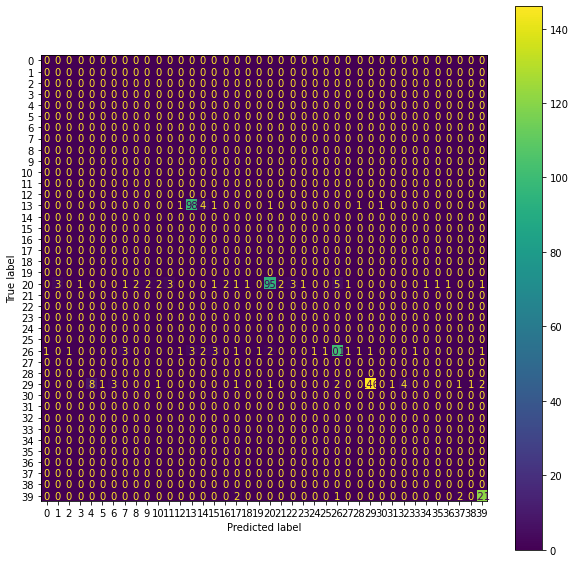

In [162]:
cm = confusion_matrix(top_n_y_eval, top_n_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)